In [3]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
from __future__ import print_function
import argparse
import os

import numpy as np
import pickle

from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Flatten, Dense, Dropout
from keras.layers import merge
from keras.optimizers import Adam, SGD, RMSprop
from keras.preprocessing.image import list_pictures, array_to_img

from image_ext import list_pictures_in_multidir, load_imgs_asarray, get_center
from create_fcn import create_fcn01, create_pupil_net00
from fname_func import load_fnames, make_fnames

np.random.seed(2016)

In [4]:
#
#  MAIN STARTS FROM HERE
#
if __name__ == '__main__':
    
    target_size = (224, 224)
    dpath_this = './'
    dname_checkpoints = 'checkpoints_pupil_net00_aug2'
    dname_checkpoints_fcn01 = 'checkpoints_fcn01'
    dname_outputs = 'outputs'
    fname_architecture = 'architecture.json'
    fname_weights = "model_weights_{epoch:02d}.h5"
    fname_stats = 'stats01.npz'
    dim_ordering = 'channels_first'
    fname_history = "history.pkl"

    # モデルを作成
    print('creating model...')
    model_pupil_net = create_pupil_net00(target_size)
    
    if os.path.exists(dname_checkpoints) == 0:
        os.mkdir(dname_checkpoints)    

creating model...


In [4]:
    #
    # Test UBIRIS Data
    #
    fnames = load_fnames('data/list_test_01.txt')
    [fpaths_xs_test,fpaths_ys_test] = make_fnames(fnames,'data/img','data/mask','OperatorA_')
    
    X_test = load_imgs_asarray(fpaths_xs_test, grayscale=False, target_size=target_size,
                                dim_ordering=dim_ordering)
    Y_test = load_imgs_asarray(fpaths_ys_test, grayscale=True, target_size=target_size,
                                dim_ordering=dim_ordering)

    # Yを初期化
    center_test = []
    for i in range(Y_test.shape[0]):
        center_test.append(get_center(Y_test[i,0,:,:]))
    center_test = np.array(center_test)

    # トレーニング時に計算した平均・標準偏差をロード    
    print('loading mean and standard deviation from ' + fname_stats + '...')
    stats = np.load(dname_checkpoints + '/' + fname_stats)
    mean = stats['mean']
    std = stats['std']
    print('==> mean: ' + str(mean))
    print('==> std : ' + str(std))

    for i in range(3):
        X_test[:, i] = (X_test[:, i] - mean[i]) / std[i]
    print('==> done')

    # test epoch 50, 100, 150, 200
    for epoch in range(50,201,50):
        # 学習済みの重みをロード
        fname_weights = 'model_weights_%02d.h5'%(epoch)
        fpath_weights = os.path.join(dname_checkpoints, fname_weights)
        model_pupil_net.load_weights(fpath_weights)
        print('==> done')
        
        # テストを開始
        outputs = model_pupil_net.predict(X_test)

        # Save Outputs
        f = open(dname_checkpoints + '/' + 'outputs.pkl','wb')
        pickle.dump(outputs,f)
        f.close

        diff = outputs - center_test;
        print('Epoch = %d'%(epoch))
        print('L2 norm av. = %f'%(np.sum(np.linalg.norm(diff,axis=1))/diff.shape[0]))
        print('Av. diff = %f, %f'%(np.sum(diff[:,0])/diff.shape[0],np.sum(diff[:,1])/diff.shape[0]))

loading mean and standard deviation from stats01.npz...
==> mean: [126.17433  90.78752  78.74256]
==> std : [61.172367 47.73529  52.325943]
==> done
==> done
Epoch = 50
L2 norm av. = 2.280641
Av. diff = -1.065711, -0.173006
==> done
Epoch = 100
L2 norm av. = 1.065147
Av. diff = 0.201740, -0.034387
==> done
Epoch = 150
L2 norm av. = 1.137701
Av. diff = -0.400912, -0.455232
==> done
Epoch = 200
L2 norm av. = 0.878085
Av. diff = 0.164751, -0.499999


In [6]:
    #
    # TEST NNLAB data
    #
    fnames = load_fnames('data.nnlab/list_test_01.txt')
    [fpaths_xs_test,fpaths_ys_test] = make_fnames(fnames,'data.nnlab/image','data.nnlab/gt','')
    
    X_test = load_imgs_asarray(fpaths_xs_test, grayscale=False, target_size=target_size,
                                dim_ordering=dim_ordering)
    Y_test = load_imgs_asarray(fpaths_ys_test, grayscale=True, target_size=target_size,
                                dim_ordering=dim_ordering)

    # Yを初期化
    center_test = []
    for i in range(Y_test.shape[0]):
        center_test.append(get_center(Y_test[i,0,:,:]))
    center_test = np.array(center_test)

    # トレーニング時に計算した平均・標準偏差をロード    
    print('loading mean and standard deviation from ' + fname_stats + '...')
    stats = np.load(dname_checkpoints + '/' + fname_stats)
    mean = stats['mean']
    std = stats['std']
    print('==> mean: ' + str(mean))
    print('==> std : ' + str(std))

    for i in range(3):
        X_test[:, i] = (X_test[:, i] - mean[i]) / std[i]
    print('==> done')

    # test epoch 50, 100, 150, 200
    for epoch in range(200,201,50):
        # 学習済みの重みをロード
        fname_weights = 'model_weights_%02d.h5'%(epoch)
        fpath_weights = os.path.join(dname_checkpoints, fname_weights)
        model_pupil_net.load_weights(fpath_weights)
        print('==> done')
        
        # テストを開始
        outputs = model_pupil_net.predict(X_test)

        # Save Outputs
        f = open(dname_checkpoints + '/' + 'outputs.pkl','wb')
        pickle.dump(outputs,f)
        f.close

        diff = outputs - center_test;
        print('Epoch = %d'%(epoch))
        print('L2 norm av. = %f'%(np.sum(np.linalg.norm(diff,axis=1))/diff.shape[0]))
        print('Av. diff = %f, %f'%(np.sum(diff[:,0])/diff.shape[0],np.sum(diff[:,1])/diff.shape[0]))

loading mean and standard deviation from stats01.npz...
==> mean: [ 126.17433167   90.78752136   78.74256134]
==> std : [ 61.1723671   47.73529053  52.32594299]
==> done
==> done
Epoch = 200
L2 norm av. = 6.149226
Av. diff = -3.532316, -1.991421


(116.356834,83.423759) - (114.898792,87.741692)(gt): 4.557459


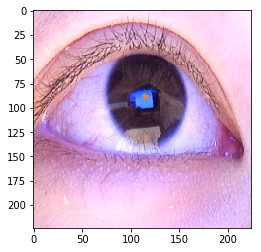

(103.989815,85.135918) - (102.283784,88.698198)(gt): 3.949732


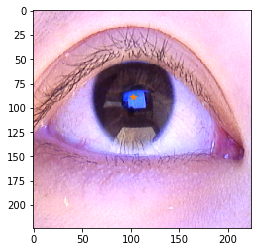

(90.613182,86.942978) - (87.000000,89.458457)(gt): 4.402581


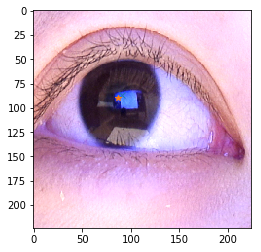

(129.082108,98.956795) - (127.635229,105.126214)(gt): 6.336812


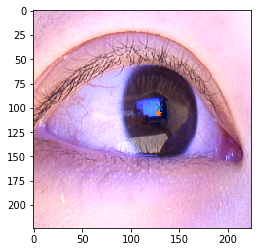

(119.060089,97.336044) - (116.081258,103.315858)(gt): 6.680689


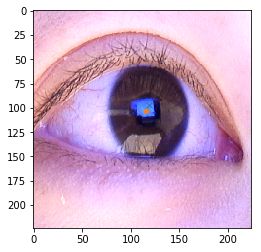

(105.189690,101.331161) - (103.665172,105.000000)(gt): 3.972975


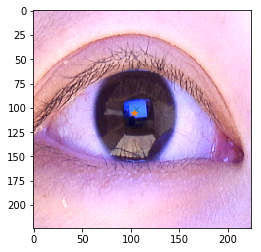

(94.252121,103.235100) - (90.937574,107.691402)(gt): 5.553814


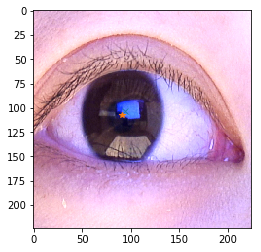

(128.645584,75.448891) - (140.308036,68.640625)(gt): 13.504268


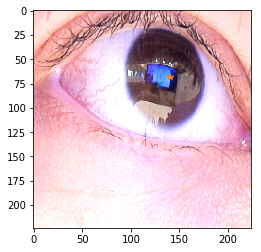

(141.038895,85.116463) - (150.560175,84.892779)(gt): 9.523908


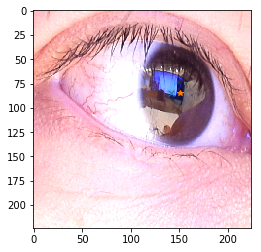

(140.326324,84.158035) - (149.611940,83.985075)(gt): 9.287227


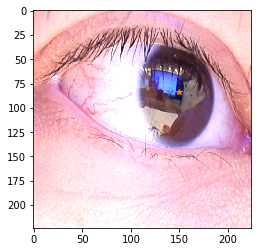

(130.597672,81.892570) - (138.000000,81.130354)(gt): 7.441468


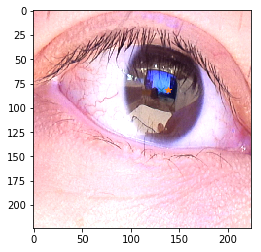

(107.829231,75.923027) - (112.057196,73.042435)(gt): 5.116003


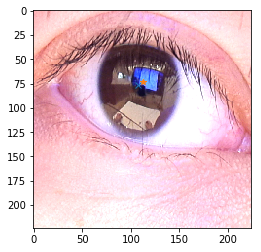

(134.528671,77.364685) - (139.675105,77.860759)(gt): 5.170288


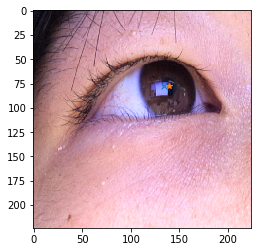

(130.640671,74.682419) - (132.974359,77.974359)(gt): 4.035216


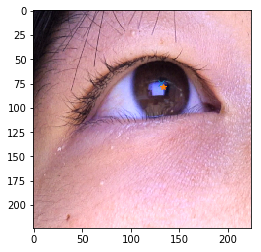

(121.507462,74.216301) - (122.000000,78.070039)(gt): 3.885086


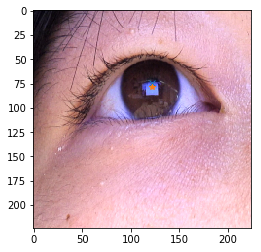

(110.076073,76.295937) - (113.096070,79.109170)(gt): 4.127307


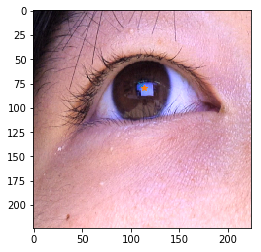

(137.781921,88.417442) - (139.790909,88.386364)(gt): 2.009228


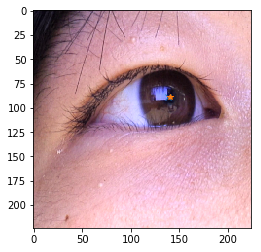

(130.990936,88.640953) - (131.414747,87.110599)(gt): 1.587954


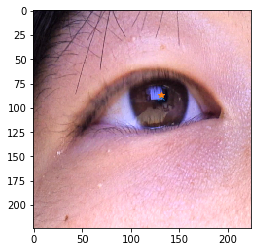

(121.329796,86.380486) - (121.372727,89.000000)(gt): 2.619866


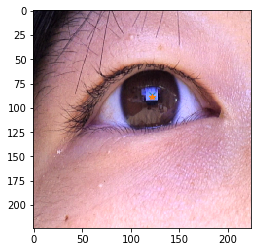

(94.752754,70.599106) - (96.463028,66.950704)(gt): 4.029376


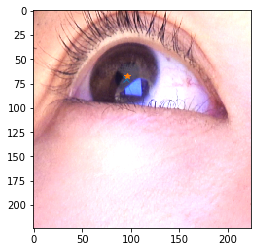

(124.259605,73.077721) - (127.219203,75.623188)(gt): 3.903668


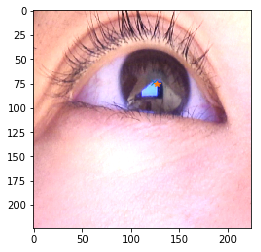

(113.961861,71.836334) - (117.574338,73.179226)(gt): 3.854005


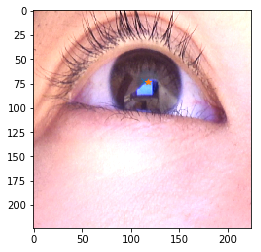

(104.497040,70.725830) - (108.506108,74.427574)(gt): 5.456697


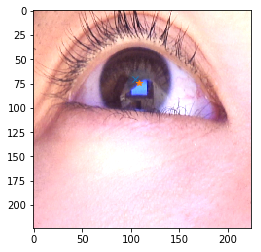

(96.501701,71.705666) - (96.051402,74.028037)(gt): 2.365625


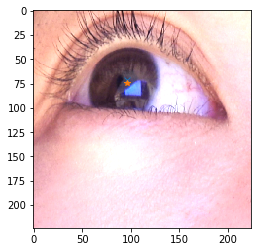

(124.595047,78.584038) - (129.669704,83.419134)(gt): 7.009301


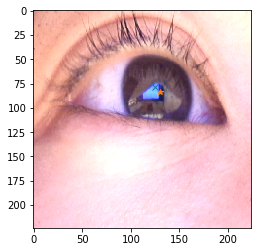

(114.120819,76.454018) - (118.000000,81.089172)(gt): 6.044229


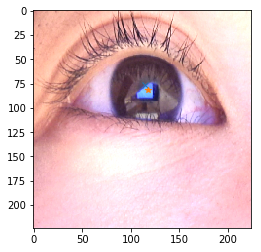

(104.344452,76.843117) - (108.088346,82.140977)(gt): 6.487224


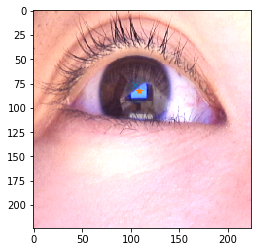

(94.496651,77.198921) - (97.500000,81.500000)(gt): 5.245892


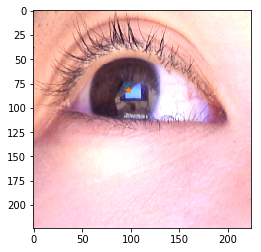

(130.100571,72.373566) - (141.807069,66.434462)(gt): 13.126883


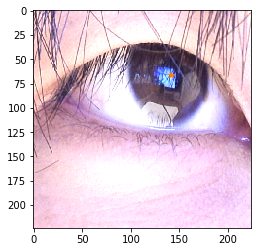

(122.500122,69.905197) - (130.872727,63.043357)(gt): 10.825219


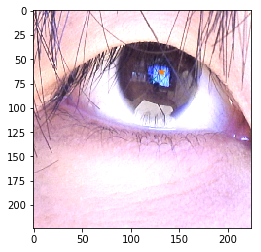

(113.212708,67.044395) - (118.283159,62.046200)(gt): 7.119792


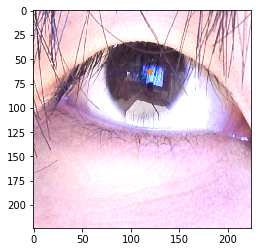

(139.461639,80.575691) - (150.897849,81.209677)(gt): 11.453770


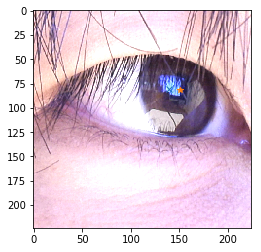

(132.806015,80.264885) - (140.627246,80.000000)(gt): 7.825715


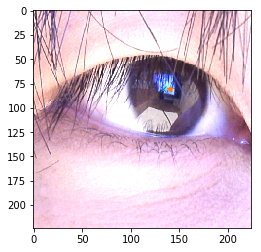

(123.674385,81.415695) - (127.925373,77.329851)(gt): 5.896187


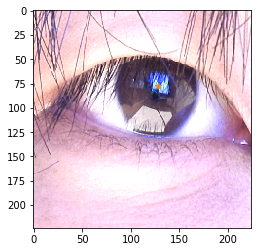

(112.493408,80.716187) - (114.671988,76.979681)(gt): 4.325238


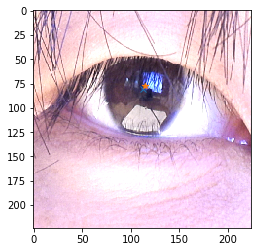

(124.195374,72.590721) - (129.596685,75.569061)(gt): 6.168036


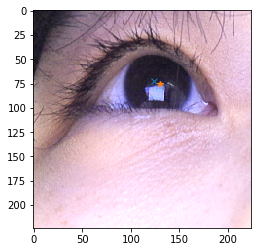

(123.581139,73.250191) - (129.592965,76.899497)(gt): 7.032744


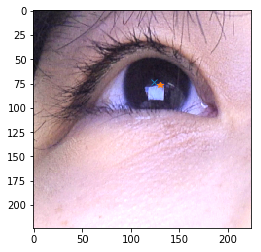

(107.460960,74.952850) - (110.859551,78.685393)(gt): 5.047999


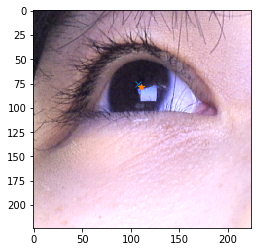

(105.795021,75.066887) - (107.228346,78.645669)(gt): 3.855140


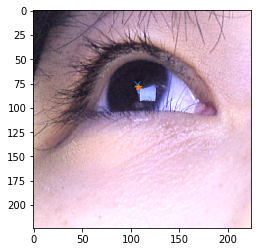

(129.945724,80.279358) - (139.664430,84.812081)(gt): 10.723749


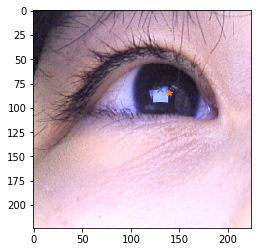

(105.789368,83.259689) - (108.490323,88.845161)(gt): 6.204245


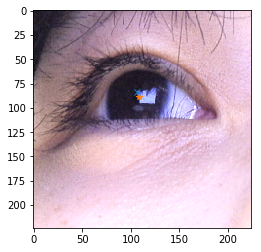

(144.734497,108.311569) - (145.981675,116.175393)(gt): 7.962109


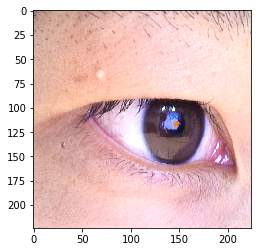

(133.761230,110.892250) - (135.620588,114.944118)(gt): 4.458121


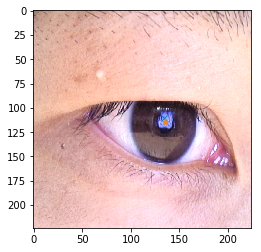

(124.648293,110.390686) - (127.110811,113.216216)(gt): 3.748015


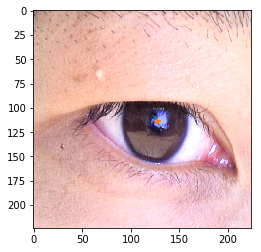

(144.628433,119.776833) - (151.976331,126.136095)(gt): 9.717604


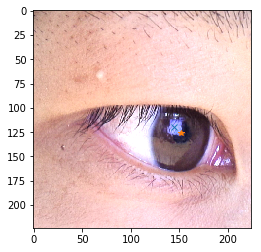

(139.770996,118.807976) - (144.425000,127.500000)(gt): 9.859566


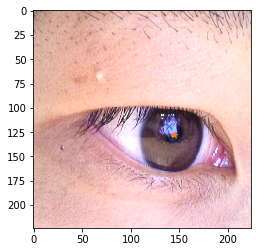

(132.326096,120.391068) - (135.042484,125.683007)(gt): 5.948393


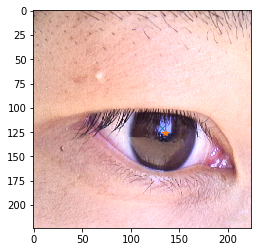

(123.540375,118.657799) - (126.234727,123.688103)(gt): 5.706443


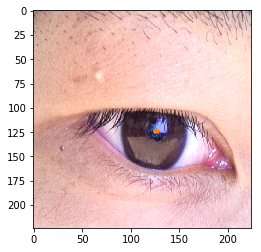

In [7]:
    from PIL import Image
    import matplotlib.pyplot as plt

    n = 0

    for i in range(len(fpaths_xs_test)):
        # テスト画像
        im1 = Image.open(fpaths_xs_test[i])
        im1 = im1.resize(target_size) 

        # Show pupil prediction
        print('(%f,%f) - (%f,%f)(gt): %f'%(outputs[i,0],outputs[i,1],
                                           center_test[i,0],center_test[i,1],
                                           np.linalg.norm(diff[i,:])))
        plt.imshow(im1)
        plt.plot(outputs[i,0], outputs[i,1],'x')
        plt.plot(center_test[i,0], center_test[i,1], '*')
        plt.show()

        n = n + 1

In [ ]:
#
#   Show History
#
mode = 'SHOW_HISTORY'
if mode == "SHOW_HISTORY":
    # load pickle
    print(dname_checkpoints + '/' + fname_history)
    history = pickle.load(open(dname_checkpoints + '/' + fname_history, 'rb'))
    
    for k in history.keys():
        plt.plot(history[k])
        plt.title(k)
        plt.show()
